<a href="https://colab.research.google.com/github/kilicdilan/deeplearning/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for NN
import matplotlib.pyplot as plt

# check PyTorch version
torch.__version__

'1.12.1+cu113'

### 01.Data (Preparing and loading)

Data can be almost anything... in machine learning.

* excel spreadsheet
* images of any kind
* videos
* audio
* DNA
* Text...

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

In [ ]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [ ]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

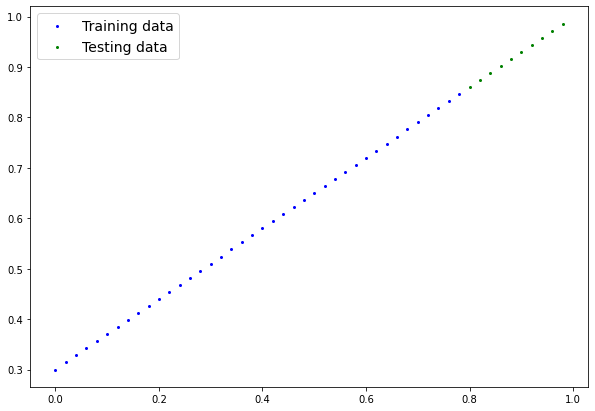

In [ ]:
plot_predictions();

### 02.Build a model

In [ ]:
# create linear regression model class

# nn.Module=base class for all neural network modules.
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,# <- start with random weights (this will get adjusted as the model learns)
            requires_grad=True, # <- can we update this value with gradient descent?
            dtype=torch.float)) # <- PyTorch loves float32 by default))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))
    
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.weights*x+self.bias # this is the linear regression formula
    


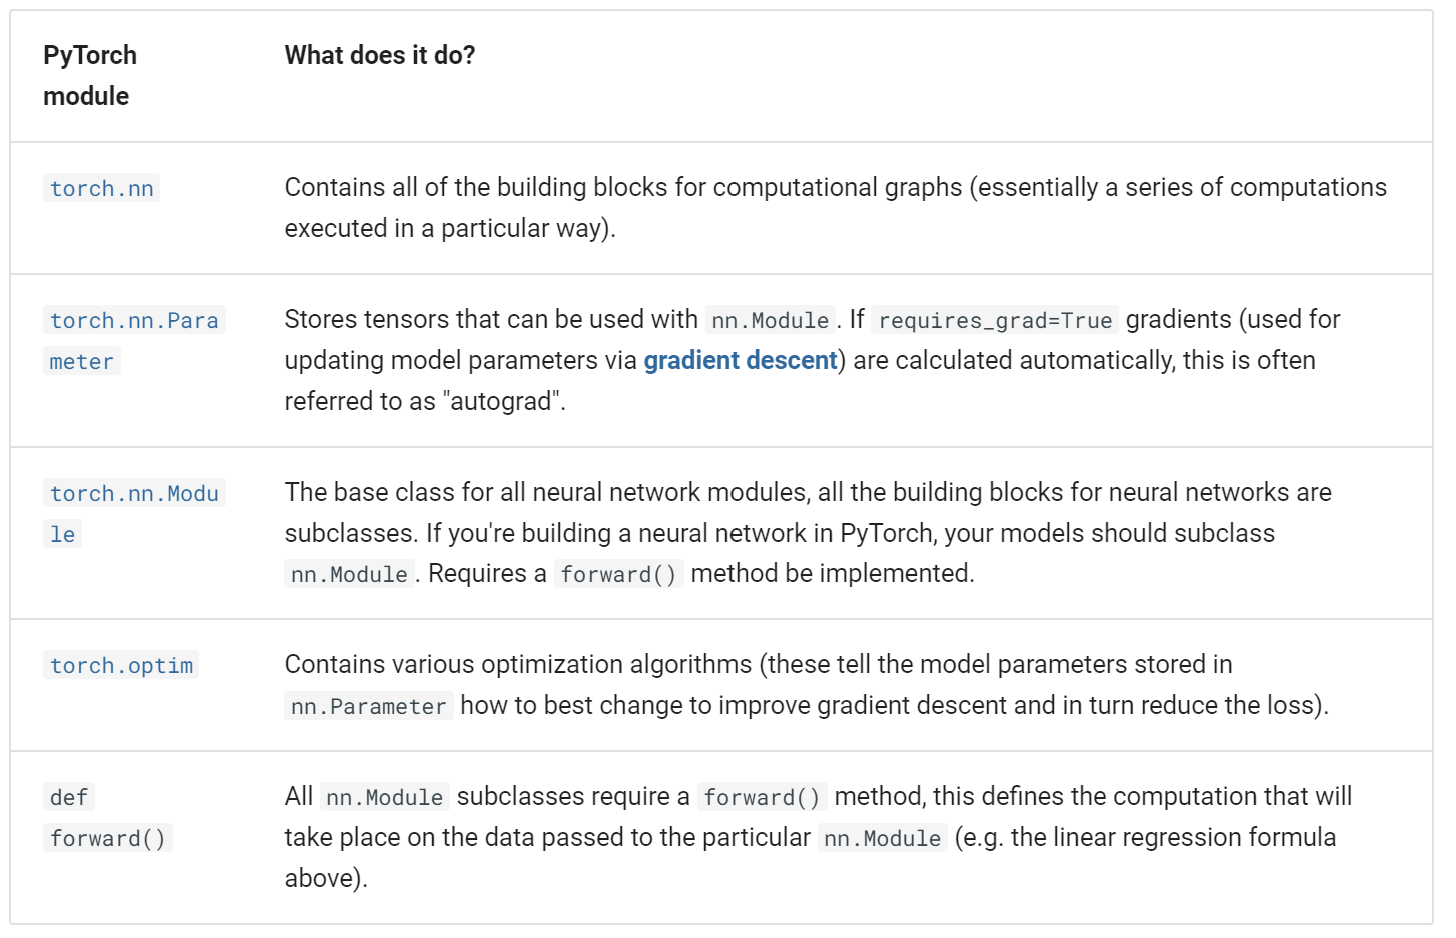

Almost everything in a PyTorch neural network comes from torch.nn,

*   *nn.Module* contains the larger building blocks (layers)
*   *nn.Parameter* contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
*   *foward()* tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
*   *torch.optim* contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data

https://pytorch.org/tutorials/beginner/ptcheat.html

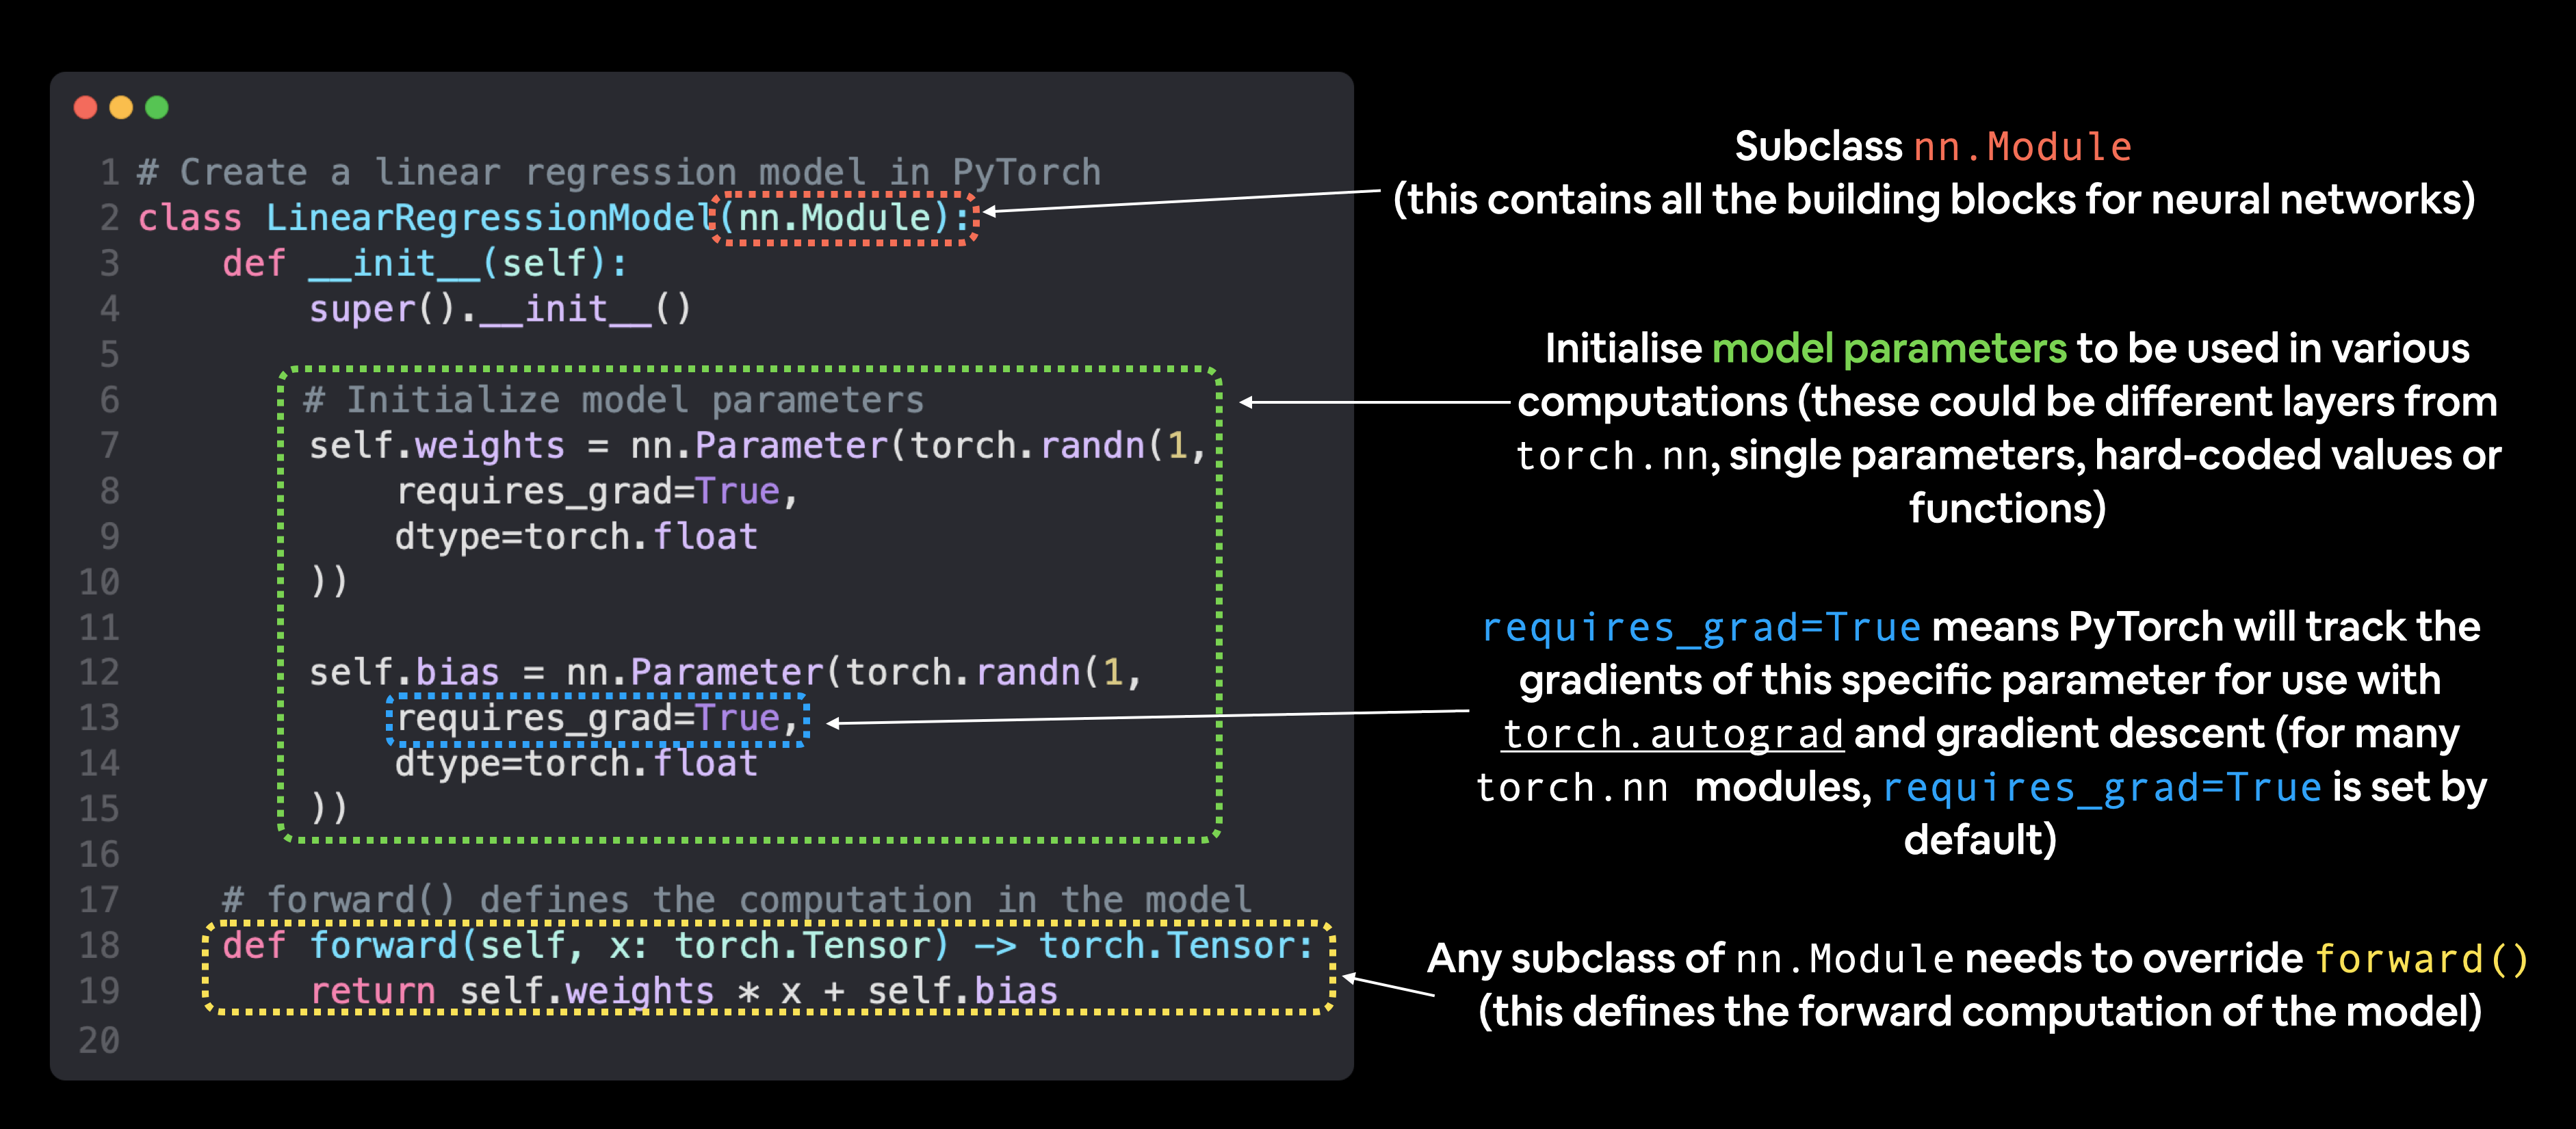

Pytorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

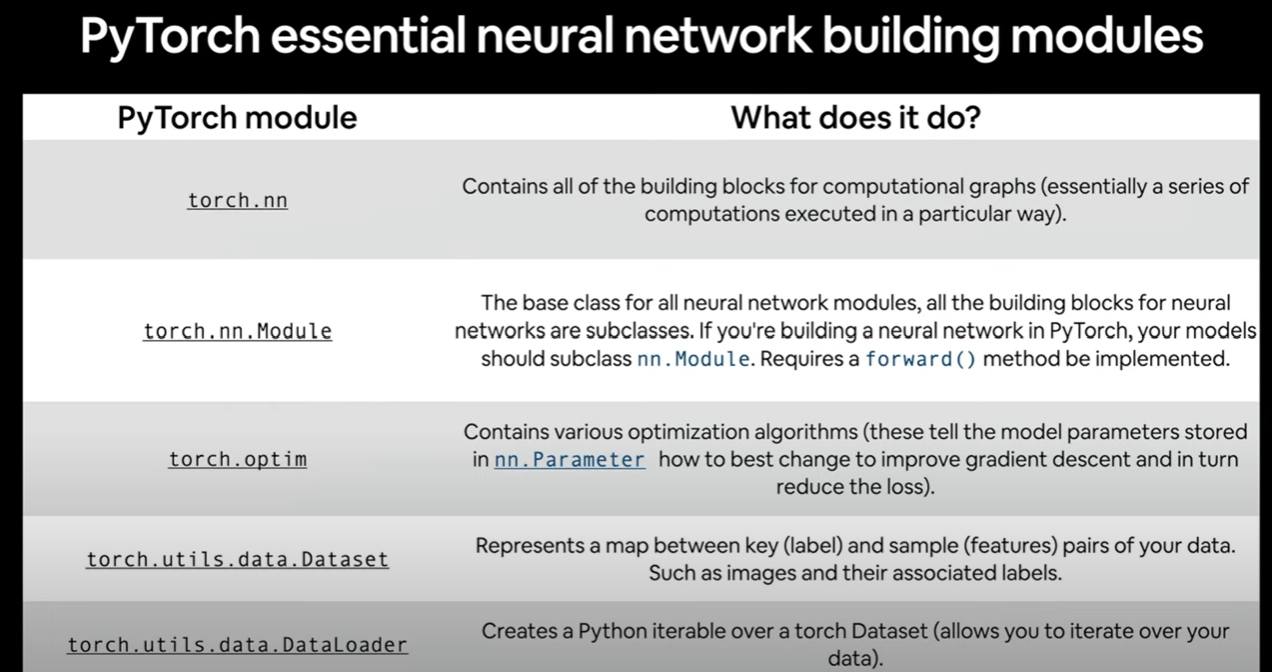

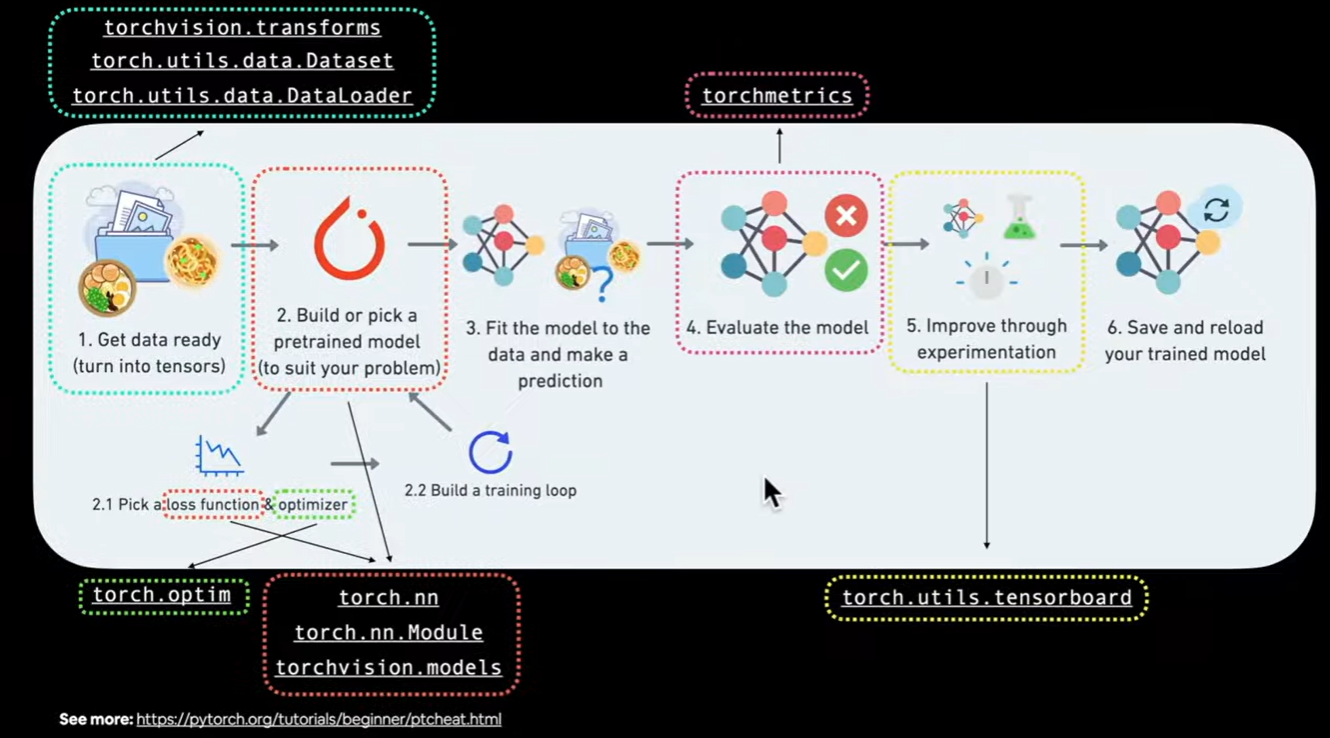

to check the model parameters -> `parameters()`


In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)

model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]), tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [ ]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

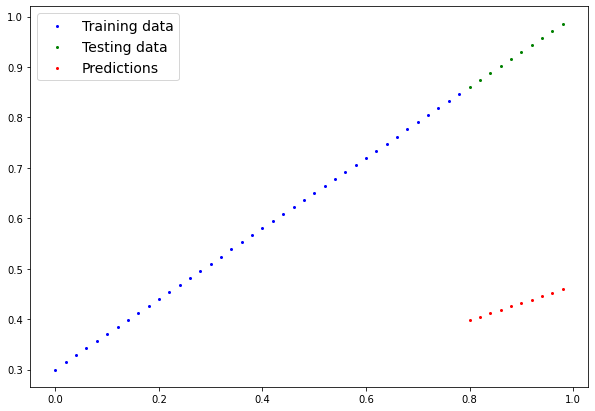

In [ ]:
plot_predictions(predictions = y_preds)

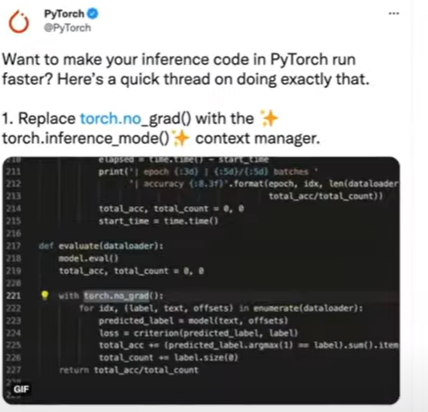

In [ ]:
with torch.no_grad():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

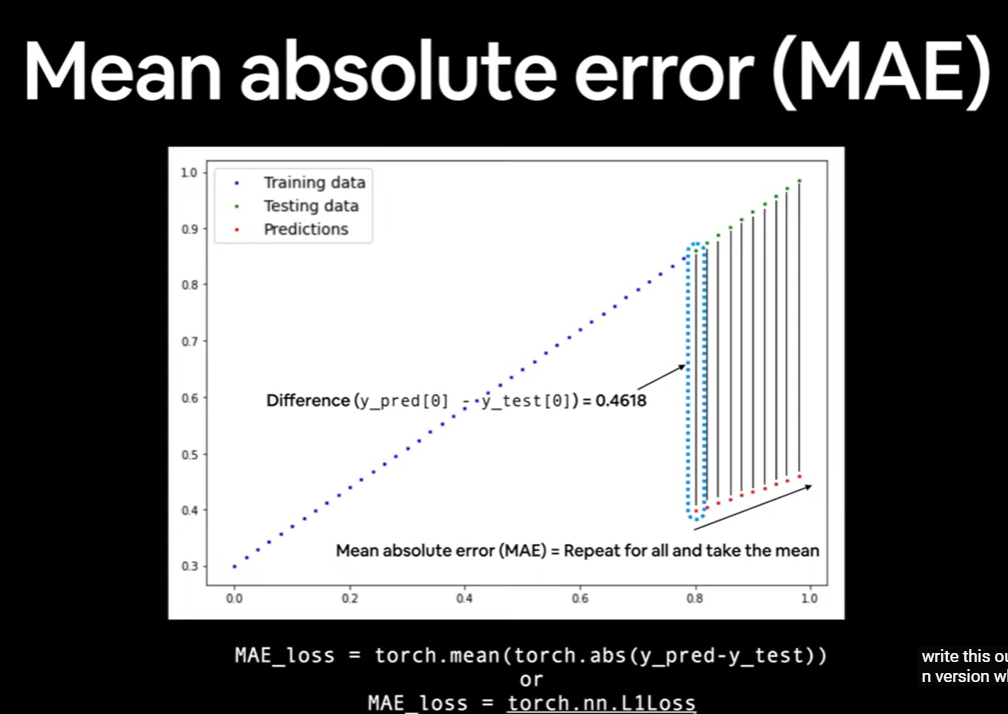

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01)  # learning rate

# Building a training loop in PyTorch
* Loop through the data
* Forward pass (this involves data moving through our model's `forward()`) - to make predictions on data - also called forward propagation
* Calculate the loss (compare forward pass predictions to ground truth labels)
* Optimizer zero grad
* Loss backward - calculate the gradients (**backpropagation**)
* Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

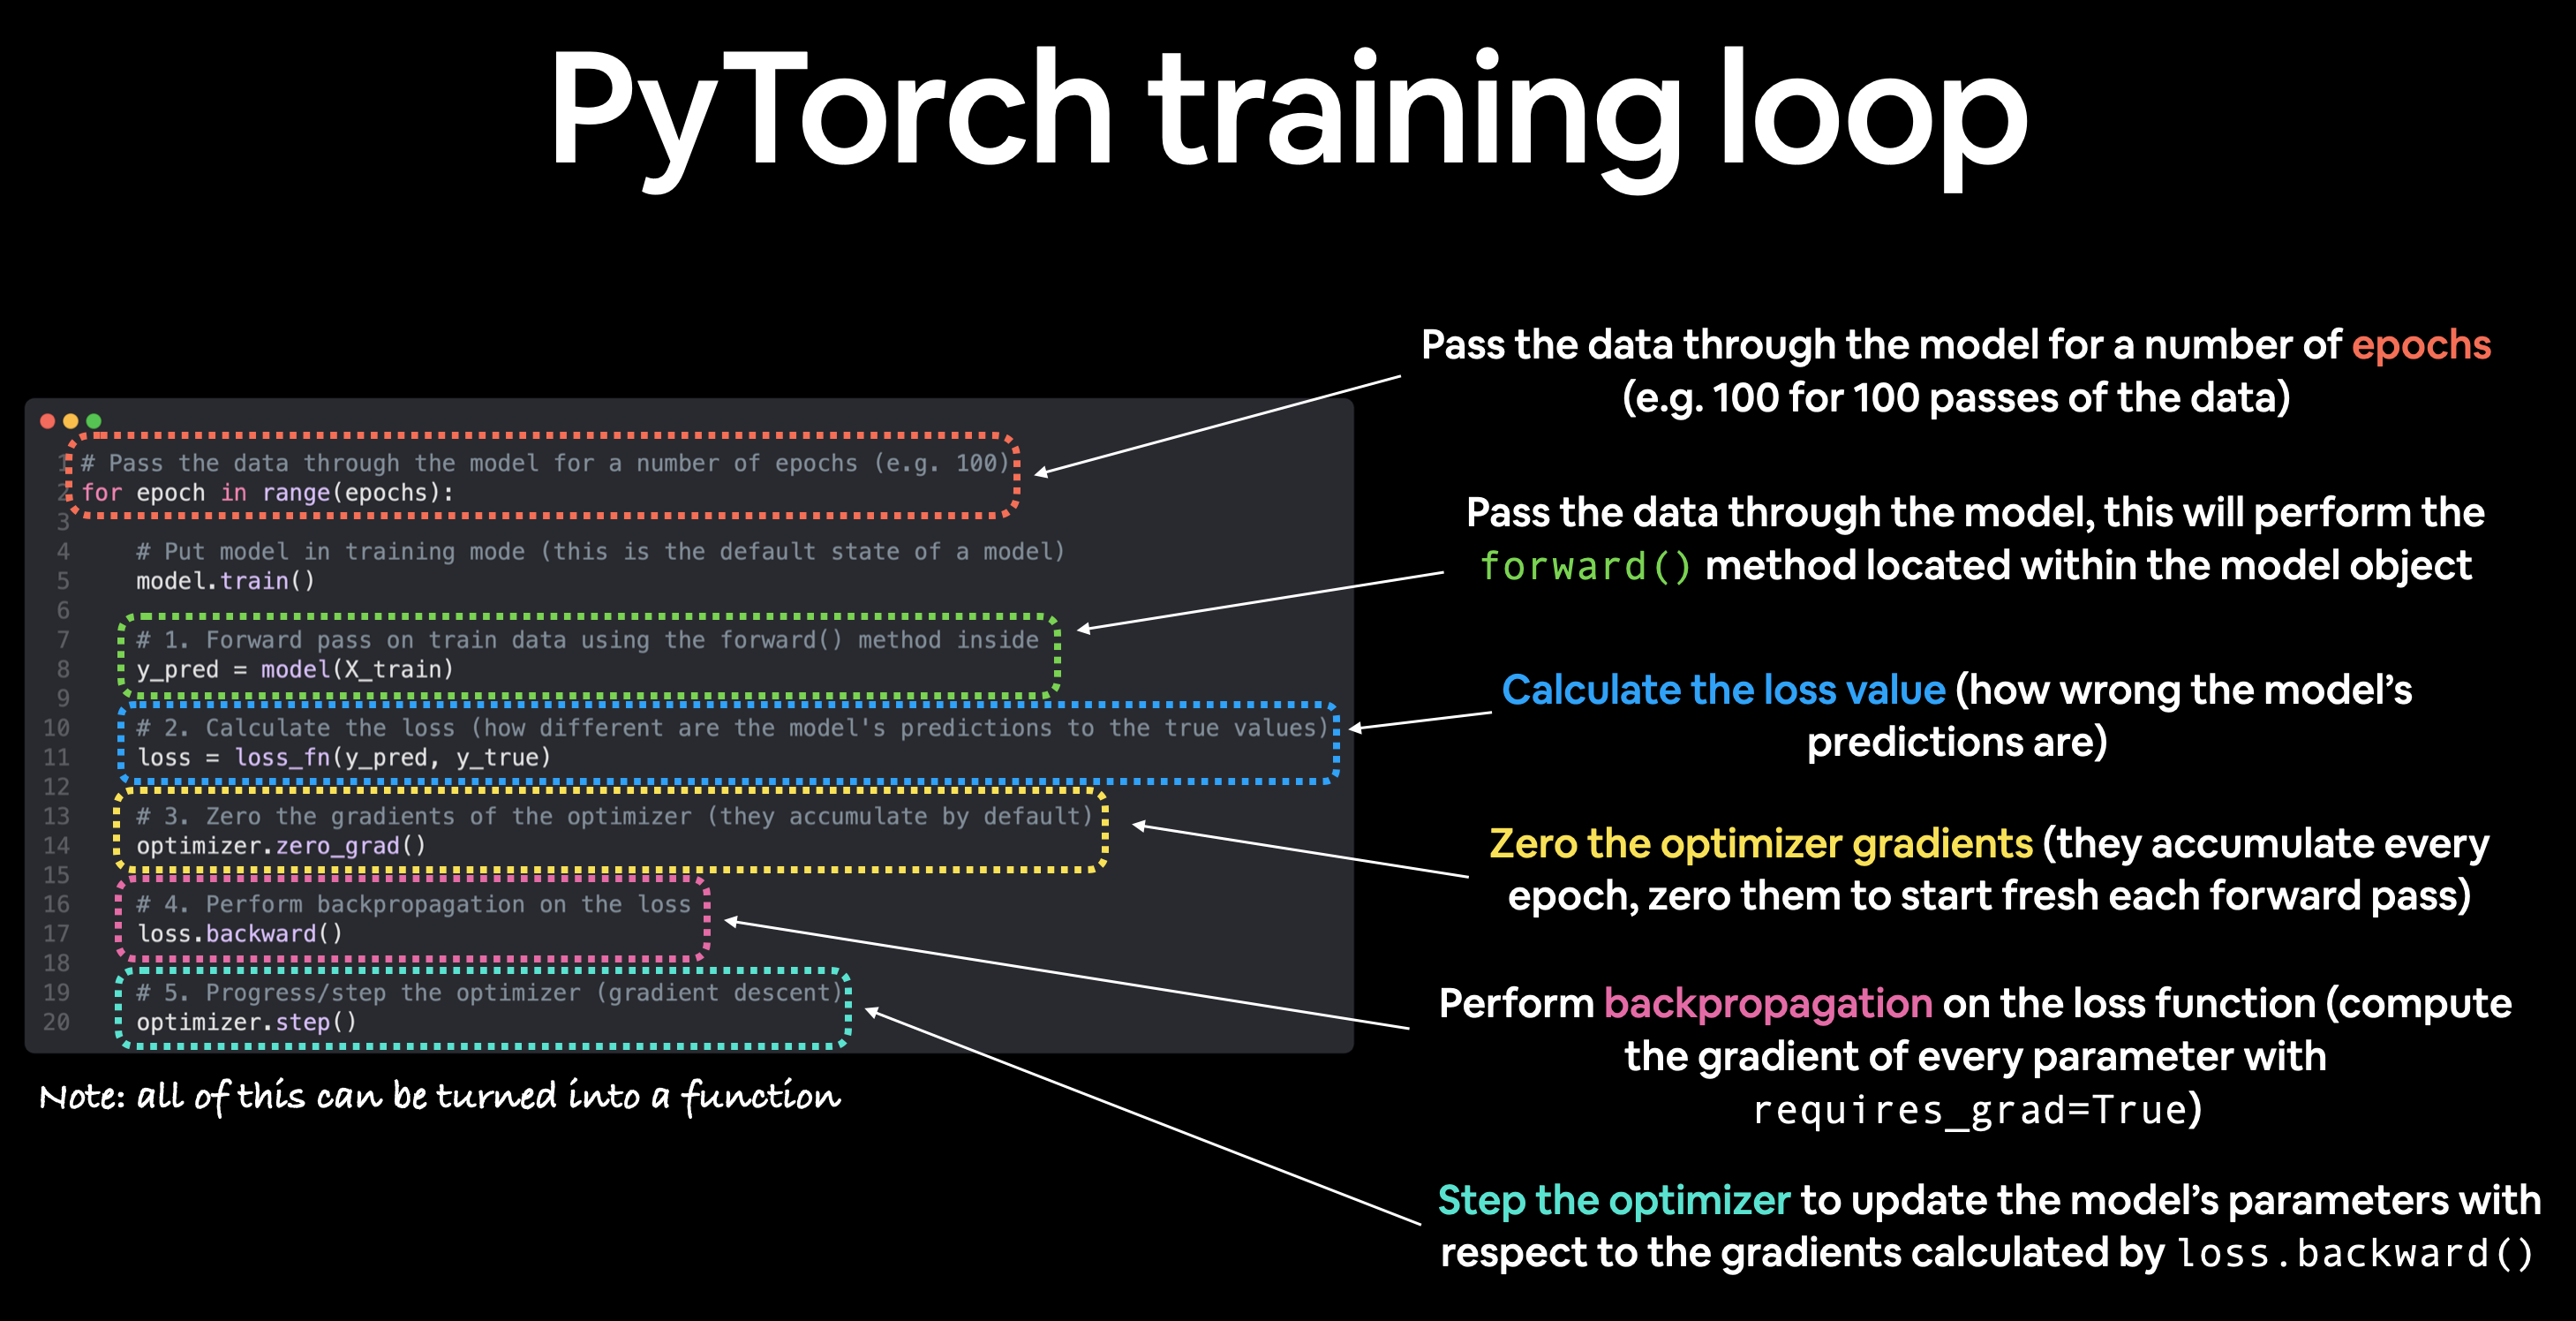

In [ ]:
torch.manual_seed(1773)

# Building a training loop in PyTorch

# An epoch is one loop through the data (this is a hyperparameter)
epochs = 100

# =======================
# Training
# =======================

# 0. Loop through the data
for epoch in range(epochs):

  # Set the model to training mode
  model_0.train()

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train) # loss(input, target)

  '''
  # Setup a loss function
  loss_fn = nn.L1Loss()
  '''

  # 3. Optimizer zero grad
  optimizer.zero_grad() # Sets gradients of all model parameters to zero.

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()


  ### Testing
  model_0.eval()  # turns off different settings in the model not needed for evaluation/testing

  with torch.inference_mode():

    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)


  # Screen printing
  if epoch % 10 ==0:
    print(f"Epoch: {epoch}  | Loss: {loss}  | Test Loss: {test_loss}")
    # List named parameters
    print(model_0.state_dict())



Epoch: 0  | Loss: 0.31288138031959534  | Test Loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10  | Loss: 0.1976713240146637  | Test Loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20  | Loss: 0.08908725529909134  | Test Loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30  | Loss: 0.053148526698350906  | Test Loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40  | Loss: 0.04543796554207802  | Test Loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50  | Loss: 0.04167863354086876  | Test Loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60  | Loss: 0.03818932920694351  | Test Loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', 

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

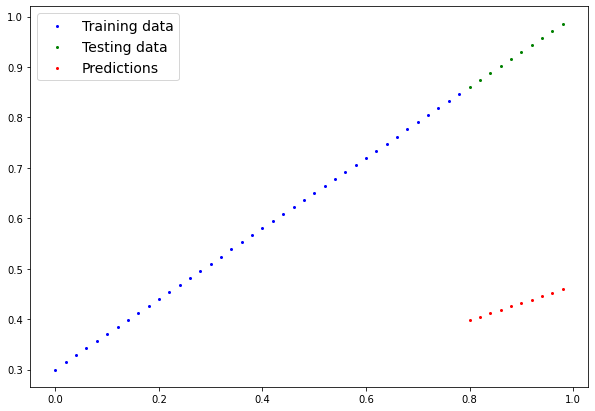

In [ ]:
plot_predictions(predictions = y_preds)

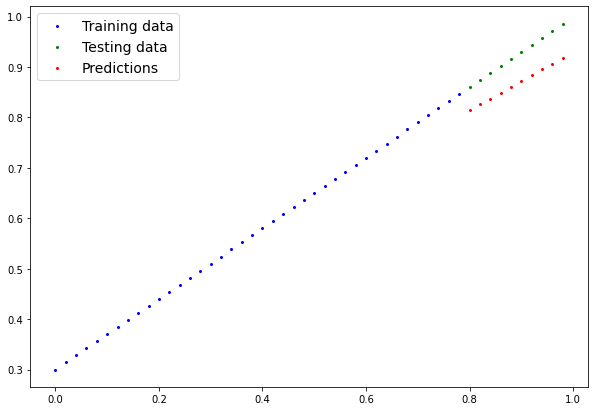

In [ ]:
plot_predictions(predictions = y_preds_new)